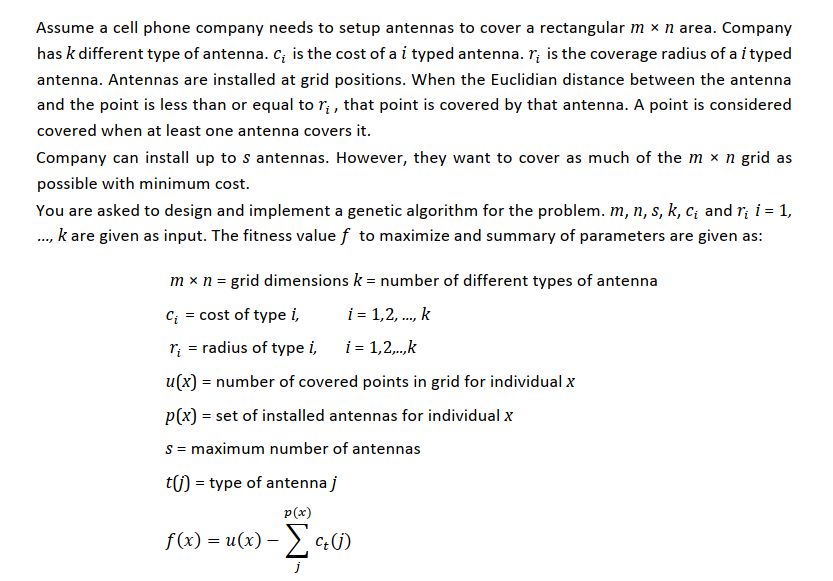

In [4]:
# Import Packages

import random
import itertools
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt

print('Packages were imported.')

Packages were imported.


In [5]:
# Defining  some Parameters and Arrays

S =  20                                             #the number of antennas that the company can install.
M =  100                                            #Length of rectangular
N =  80                                             #Width  of rectangular
K =  10                                              #the number of antenna types that company has.

k   = np.arange(K+1, dtype = int)                   #List of antenna's types, k = 0 means, no antenna.  
C_k = np.log2(np.exp(k))*7                          #An arbitrary definition of costs
r_k = 2*k                                           #The coverage radius of the antenna i'th

print('parameters were defined as below:','\n'
     f'Number of Antenna: {S}', '\n'
     f'The Rectangular is: {M} * {N}','\n'
     f'The count of Antennas is: {K}', '\n'
     'To define the cost and coverage radius of each Antenna we defined them arbitrarily')

parameters were defined as below: 
Number of Antenna: 20 
The Rectangular is: 100 * 80 
The count of Antennas is: 10 
To define the cost and coverage radius of each Antenna we defined them arbitrarily


### Required Function

In [6]:
def gen_init():
    '''Generate a random solution, 
       Is returned a NumPy array that represented antenna type
       and coordinates of antenna location'''
    
    s = np.zeros((3,S), dtype = int)
    for i in range(S):
        s[0,i] = np.random.randint(0,K+1)
        s[1,i] = np.random.randint(0,M+1)
        s[2,i] = np.random.randint(0,N+1)
    return s

In [7]:
def coverage(point, r):
    
    '''It takes coordinate of points and radius and checks 
       all points that has covered by that point. it uses 
       circle to find covered points out.'''
    
    grid = []
    x, y = point[0], point[1]
    if r>0:
        for i in range(max(0,x-r), x+r+1):
            for j in range(max(0,y-r), y+r+1):
                if (i-x)^2 + (j-y)^2 <= r^2:
                    grid.append((i,j))
    else: grid
    return grid

In [8]:
def function_1(gen):
    '''
    This function returns coordinate and radius of each antenna, 
    and also computes total cost of all antenna that installed
    '''
    points = [i for i in zip(gen[1,:], gen[2,:])]
    cost = round(sum([C_k[int(i)] for i in gen[0,:]]), 2)
    radius = [r_k[int(i)] for i in gen[0,:]]
    return (points, radius,  cost)

In [9]:
def function_2(p):
    
    '''To compute fitness of each gen or solution.'''
    
    U = set()
    for j in range(S):
        gride = coverage(p[0][j], p[1][j])
        temp = {i for i in gride}
        U = U.union(temp)
    fit = round(len(U) - p[2], 2)
    return fit

In [10]:
def function_3(population):
    
    '''computes fitness of each individual of population,
       returns pop_fit (dictionary) respect to fintness as key.'''
    
    pop_fit = {}
    pop_size = len(population)
    for i in range(pop_size):
        p= function_1(population[i])
        pop_fit.update({function_2(p):population[i]})
    return pop_fit

In [11]:
def Tournament_selection(k, Mu, pop_fitnes):
    
    '''Randomly chooses K individual of the population and 
       selects the best one it repeats this selection strategy for Mu times.'''
    if len(pop_fitnes)>=k:   
        parents = {}
        for i in range(Mu):
            per = random.sample(list(pop_fitnes.keys()), k)
            parents[i] = pop_fitnes[max(per)]
    else: parents = pop_fitnes
    return parents

In [12]:
def mutation(gen, crom):
    
    '''Randomly changes crom'th of gen '''
    
    gen[0,crom] = np.random.randint(0,K+1)
    gen[1,crom] = np.random.randint(0,M+1)
    gen[2,crom] = np.random.randint(0,N+1)
    return gen

In [13]:
def reproduction_1(child_size, mutation_rate, Parent):
    
    '''takes parents and child size and returns offspring.
       for generation uses one point crossover.'''
    
    children = dict()
    keys = list(Parent.keys())
    random.shuffle(keys)
    for i in range(child_size//2):
        r = random.sample(keys, 1)
        pare_1 = Parent[r[0]]
        r = random.sample(keys, 1)
        pare_2 = Parent[r[0]]
        cross_point = np.random.randint(1, S)
        child_1 = pare_1[:, :cross_point]
        child_2 = pare_2[:, :cross_point]
        child_1 = np.concatenate((child_1, pare_2[:, cross_point:]), axis=1)
        child_2 = np.concatenate((child_2, pare_1[:, cross_point:]), axis=1)
        if np.random.uniform() <= mutation_rate:
            rand = np.random.randint(0,S, 2)
            child_1 = mutation(child_1, rand[0])
            child_2 = mutation(child_2, rand[1])
        children[2*i]   = child_1
        children[2*i+1] = child_2
    return children

In [14]:
def reproduction_2(child_size, mutation_rate, Parent):
    
    '''takes parents and child size and returns offspring.
       for generation uses Uniform Crossover.'''
    
    children = dict()
    keys = list(Parent.keys())
    random.shuffle(keys)
    for i in range(child_size):
        r = random.sample(keys, 1)
        pare_1 = Parent[r[0]]
        r = random.sample(keys, 1)
        pare_2 = Parent[r[0]]
        temp1 = np.array([np.random.uniform() for i in range(S)])>=0.5
        temp2 = 1 - temp1
        child = pare_1*temp1 + pare_2*temp2
        if np.random.uniform() <= mutation_rate:
            rand = np.random.randint(0,S)
            child= mutation(child, rand)
        children[i] = child
    return children

In [15]:
def Survival_Selection_1(pop,pop_size, worst_chance):
    
    '''Elitism Replacement. 
       the worst gen will be selected with WORST_CHANCE probability'''
    
    pop = {k:v for k,v in sorted(pop.items() , key=lambda item: item[0], reverse=True)}
    keys = list(pop.keys())
    if np.random.uniform()<= worst_chance:
        key   = keys[-1]
        value = pop[key]
        pop = dict(itertools.islice(pop.items(), pop_size-1)) 
        pop.update({key:value})
    else:
        pop = dict(itertools.islice(pop.items(), pop_size))
    return pop

In [16]:
def Survival_Selection_2(pop,pop_size):
    
    '''Generation Model or Steady State Model. 
       This method takes Children (new generation) and returns pop_size best children as
       new or next population. Size of Children in this method had to be bigger than pop_size.'''
    
    pop = {k:v for k,v in sorted(pop.items() , key=lambda item: item[0], reverse=True)}
    pop = dict(itertools.islice(pop.items(), pop_size))
    return pop

## Genetic Algorithm.

### 1- Algorithm Parameters

In [22]:
Population_Size = 100                         #Size of Population in each iteration 
N_K             = 30                           #Number of parents that are selected for the tournament
Mu              = 60                          #Size of the population of parents to generation.
Child_Size      = 100                          #Size of the population of children in each iteration.
Mutation_Rate   = 0.19                        #Each child will be mutated with Mutation_rate percent.
Worst_Chance    = 0.1                        #With the Worst_Chance percent the worst individual is moved to the next population.
Iteration       = 20                          #Number of iteration to run algorithm.
Repetition      = 4

### 2-Algorithm Variables

- **Initial_Population:**_to save first random generation_.
- **Population_Fitness:** _To save population with its fitness in each iteration_.
- **Parents**: _To save population of Parents for generation_.
- **Children**: _To save offspring generated by parents_.
- **Children_fitness**: _To save fitness of each child_.
- **Total_population**: _To save the previous and next population_. 
- **Worst_fitness**: _To save worst fitness of  individual of each iteration_.
- **Best_fitness**: _To save best fitness of individual of each iteration_.
- **Average_fitness**: _To save the average of fitness of population in each iteration_.


### 3- Algorithm body.

In [28]:
Best             = dict()
Average          = dict()
Worst            = dict()
Servival_Selection_Method = 'Generation_Model'                         #"Generation_Model"   or    "Elitism_Replacement"

for w in range(Repetition):
    Worst_fitness    = []
    Best_fitness     = []
    Average_fitness  = []
    Initial_Population = {i:gen_init() for i in range(Population_Size)}

    Population_Fitness = function_3(Initial_Population)

    for i in range(Iteration):
    
        Total_Population = dict()
    
        Keys = list(Population_Fitness.keys())
        Worst_fitness.append(min(Keys))
        Best_fitness.append(max(Keys))
        Average_fitness.append(mean(Keys))
    
        Parents  = Tournament_selection(N_K, Mu, Population_Fitness)
    
        Children = reproduction_2(Child_Size, Mutation_Rate, Parents)
    
        Children_fitness = function_3(Children)
    
        if Servival_Selection_Method == 'Elitism_Replacement':
            Total_Population.update(Population_Fitness)
            Total_Population.update(Children_fitness)
    
            Population_Fitness = Survival_Selection_1(Total_Population, Population_Size, Worst_Chance)
        elif Servival_Selection_Method == 'Generation_Model':
            Population_Fitness = Survival_Selection_2(Children_fitness, Population_Size)
        
        else: 
            print('You should Select Servival Selection Method respect to available methods.')
            break
        print(f'In iteration number: {i} for Repetition {w}', f'best so far is:{Best_fitness[-1]}')
    print('\n', '='*35, 'next Repetition','='*36,'\n')    
    Best[w]    = Best_fitness
    Worst[w]   = Worst_fitness
    Average[w] = Average_fitness

In iteration number: 0 for Repetition 0 best so far is:6971.83
In iteration number: 1 for Repetition 0 best so far is:8088.65
In iteration number: 2 for Repetition 0 best so far is:8536.76
In iteration number: 3 for Repetition 0 best so far is:8821.66
In iteration number: 4 for Repetition 0 best so far is:8919.76
In iteration number: 5 for Repetition 0 best so far is:9006.96
In iteration number: 6 for Repetition 0 best so far is:9108.57
In iteration number: 7 for Repetition 0 best so far is:9214.47
In iteration number: 8 for Repetition 0 best so far is:9268.97
In iteration number: 9 for Repetition 0 best so far is:9312.36
In iteration number: 10 for Repetition 0 best so far is:9366.86
In iteration number: 11 for Repetition 0 best so far is:9378.47
In iteration number: 12 for Repetition 0 best so far is:9385.76
In iteration number: 13 for Repetition 0 best so far is:9459.55
In iteration number: 14 for Repetition 0 best so far is:9492.75
In iteration number: 15 for Repetition 0 best so f

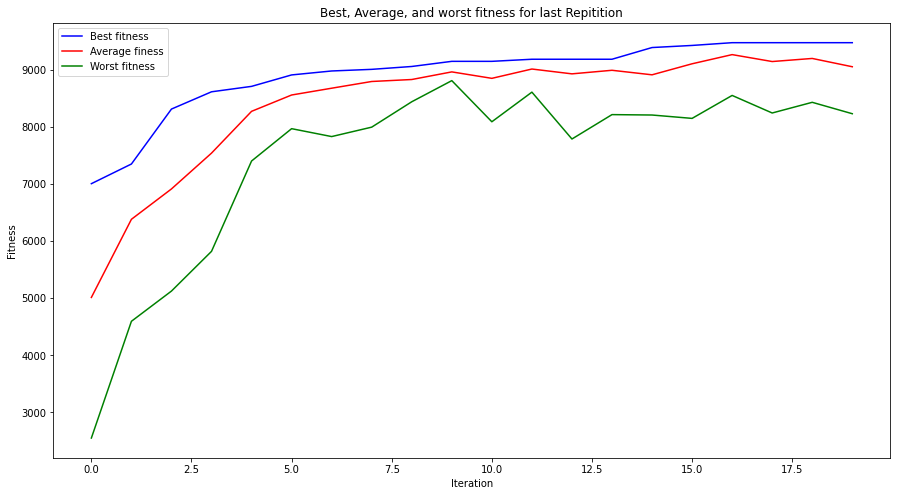

In [29]:
plt.figure(figsize=(15,8))
plt.plot(Best_fitness, c = 'blue', label = 'Best fitness')
plt.plot(Average_fitness, c = 'red', label = 'Average finess')
plt.plot(Worst_fitness, c = 'green', label = 'Worst fitness')
plt.legend()
plt.title('Best, Average, and worst fitness for last Repitition')
plt.ylabel('Fitness')
plt.xlabel('Iteration')
plt.show()

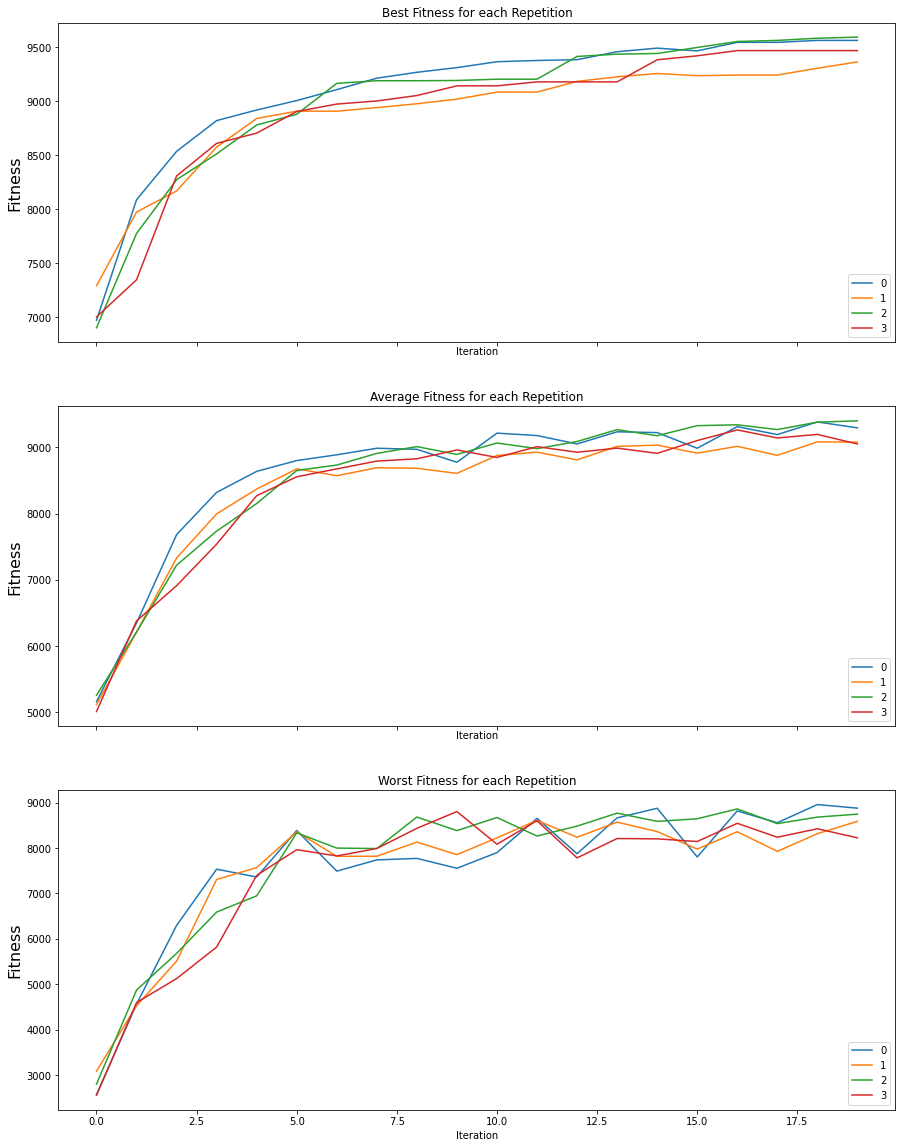

In [30]:
fig,ax = plt.subplots(3,1, figsize = (15,20), sharex=True)

for w in range(Repetition):
    ax[0].plot(Best[w], label = w)
    ax[1].plot(Average[w], label = w)
    ax[2].plot(Worst[w], label = w)

for w in range(3):
    ax[w].set_xlabel('Iteration')
    ax[w].set_ylabel('Fitness', fontsize = 16)
    ax[w].legend(loc = 'lower right')

ax[0].title.set_text('Best Fitness for each Repetition')
ax[1].title.set_text('Average Fitness for each Repetition')
ax[2].title.set_text('Worst Fitness for each Repetition')
plt.show()